In [ ]:
!pip install transformers

In [ ]:

!pip install pyyaml==5.4.1


In [44]:
from bs4 import BeautifulSoup as bs
import requests
import re
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoModelForTokenClassification
from tqdm import tqdm
nltk.download('punkt')
nltk.download("stopwords")

import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
url_search = 'https://www.aljazeera.com/where/mozambique/'
base_url = 'https://www.aljazeera.com'

In [3]:
response = requests.get(url_search)

In [4]:
soup = bs(response.text, 'html.parser')
 
urls = []
cnt = 0
for link in soup.find_all('a'):
    if link.get('class') == ['u-clickable-card__link']:
        sublink = link.get('href')
        if sublink.split('/')[1] != 'program':
          if cnt >= 10:
            break

          urls.append(sublink)
          cnt += 1



In [5]:
scraped_articles = []

for each_url in urls:
  article_url = base_url + each_url

  article_response = requests.get(article_url)

  a_soup = bs(article_response.text, 'html.parser')

  article_tags = a_soup.find_all('p')

  article_text = ""

  for item in article_tags[:-1]: # Ignoring the unnecessary line "Follow AlJazeera English"
    article_text += item.text

  scraped_articles.append(article_text)

In [6]:
# Save the article as a JSON file

import json
with open('scraped_data.json', 'w') as f:
  json.dump(scraped_articles, f, ensure_ascii=False)

In [9]:
clean_text = []

for art in tqdm(scraped_articles):

  art = art.replace("\n", "")
  art = art.replace("–", "")

  all_links = re.findall('(https:.*?)\s', art + ' ')

  for i in all_links:
      art = art.replace(i, '')

  all_picture_links = re.findall('(pic.twitter.com.*?)\s', art + ' ')

  for i in all_picture_links:
      art = art.replace(i, '')

  all_mentions = re.findall('(@.*?)\s', art + ' ')

  for i in all_mentions:
      art = art.replace(i, '')

  tokens = word_tokenize(art.replace('-', ''))

  tokens = [w.lower() for w in tokens ]

  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]

  words = [word for word in stripped if word.isalpha() ]

  stop_words = set(stopwords.words('english'))

  words = [w for w in words if not w in stop_words]
  phrase = " ".join(words)

  clean_text.append(phrase)

100%|██████████| 10/10 [00:00<00:00, 73.41it/s]


In [10]:
print(clean_text)

['floods happening month torrential rains killed people kwazulu natal provinceheavy rains south africa forced hundreds people flee homes east coast according officials month worst floods living memory killed floods weekend hit infrastructure roads bridges damaged buildings mainly port city durban capital kwazulunatal province home million people areas inaccessible become islands stage kwazulunatal premier sihle zikalala said news conference sundayno fatalities immediately recorded zikalala added yet receive full comprehensive report impact latest heavy rains reports come worrying picture however emerging april torrential rain led floods landslides death people kwazulunatal authorities said survivors left without drinking water nearly two weeks repairs still ongoing floods caused damage worth hundreds millions dollarson sunday parts road near umdloti beach resort north durban washed away leaving gaping holes cars balanced edge afp news agency reported flooding started late yesterday sat

In [11]:
# Download and load FinBert pretrained model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

nlp = pipeline("sentiment-analysis", model = model, tokenizer=tokenizer)

possible_sentiments = ['negative', 'neutral', 'positive']

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

In [12]:
from collections import defaultdict

def call():
  return []


# Get sentiments
def get_sentiments(input_dict):

  sentiments = []

  for item_ in tqdm(input_dict):
    if len(item_) <=512: # Maximum length of the string that the model can handle is 512.
      sentiments.append(nlp(item_))

    else:
      l = len(item_)

      temp_score = []

      for c in range(0, l, 512):
        temp_score.append(nlp(item_[c+1:512+c+1]))

      d = defaultdict(call)
      for es in temp_score:
          d[es[0]['label']].append(es[0]['score'])

      max_ = -1
      for key, val in d.items():
        d[key] = sum(val)/len(val) # averge of all the scores of one sentiment
        if d[key] >= max_:
          max_ = d[key]
          final_sentiment = key

      sentiments.append([{final_sentiment : max_ }])

  return sentiments


results = get_sentiments(clean_text)

100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


In [24]:
results

[[{'negative': 0.7500664393107096}],
 [{'negative': 0.7959129214286804}],
 [{'negative': 0.9439936280250549}],
 [{'negative': 0.7576077356934547}],
 [{'negative': 0.8087353855371475}],
 [{'positive': 0.8347870707511902}],
 [{'negative': 0.793030035495758}],
 [{'positive': 0.7791613340377808}],
 [{'neutral': 0.8623008728027344}],
 [{'negative': 0.7552738785743713}]]

In [40]:
final_sen = {'positive' : 0, 'negative' : 0, 'neutral' : 0}
for r in results:
  for key,val in r[0].items():
    final_sen[key] += 1

{'negative': 7, 'neutral': 1, 'positive': 2}

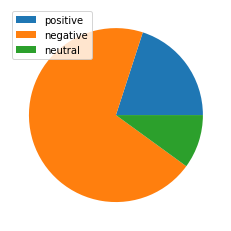

In [48]:
plt.pie([val for key,val in final_sen.items()])
plt.legend([key for key,val in final_sen.items()])
plt.savefig('Visualization.png')